In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve
import glob
import os

## import data

In [9]:
base = "/Users/ivankoh/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/1D/NUS Y3S1/BT4222/Data"
train_path = max(glob.glob(base + '/train/*.csv'), key=os.path.getctime) 
print(train_path)
df = pd.read_csv(train_path)
X_train, y_train = df.drop('state', axis=1), df['state']

test_path = max(glob.glob(base + '/test/*.csv'), key=os.path.getctime) 
print(test_path)
test = pd.read_csv(test_path)

X_test, y_test = test.drop('state', axis=1), test['state']

/Users/ivankoh/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/1D/NUS Y3S1/BT4222/Data/train/kickstarter_train_final_20221022-142838.csv
/Users/ivankoh/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/1D/NUS Y3S1/BT4222/Data/test/kickstarter_test_final_20221022-162938.csv


## best classifiers 

In [15]:
#SVC 
svc_best = {'kernel': 'linear', 'gamma': 0.1, 'C': 0.001, 'probability':True}
svc_clf = SVC(**svc_best)
svc_clf.fit(X_train, y_train)

#LOGISTIC REGRESSION
lr_clf = LogisticRegression(C=0.02071613012624668, penalty='l2', solver='newton-cg')
lr_clf.fit(X_train, y_train)

#RANDOM FOREST
rf_best = {'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 8,
 'bootstrap': False}
rf_clf = RandomForestClassifier(**rf_best)
rf_clf.fit(X_train, y_train)

#XGBOOST 
xgb_clf = xgb.XGBClassifier(learning_rate=0.02,
                                          max_depth=3,
                                          n_estimators=3000,
                                          subsample=0.5,
                                          colsample_bytree=0.25,
                                          eval_metric='auc',
                                          verbosity=1,
                                          use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

#y_pred_test = best_clf.predict(X_test)

/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.25,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [16]:
svc_best = {'kernel': 'linear', 'gamma': 0.1, 'C': 0.001, 'probability':True}
svc_clf = SVC(**svc_best)
svc_clf.fit(X_train, y_train)

SVC(C=0.001, gamma=0.1, kernel='linear', probability=True)

## NB

In [17]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
binary_cols = ['staff_pick', 'has_video']
train_numeric = X_train1.select_dtypes(include='number').drop(binary_cols, axis=1) 
test_numeric = X_test1.select_dtypes(include='number').drop(binary_cols, axis=1) 

for i, col in enumerate(train_numeric.columns):
    X_train1[col], val = pd.qcut(X_train1[col], 5, retbins = True, duplicates = 'drop')
    X_test1[col] = pd.cut(X_test1[col], bins = val, duplicates = 'drop', include_lowest=True)
    
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
X_train1_fitted = enc.fit_transform(X_train1)
X_test1_fitted = enc.transform(X_test1)
imp = SimpleImputer(strategy="most_frequent") # impute nan values
X_train1_fitted = imp.fit_transform(X_train1_fitted)
X_test1_fitted = imp.transform(X_test1_fitted)

model_C = CategoricalNB(alpha=1.873817422860387e-09)
clf_C = model_C.fit(X_train1_fitted, y_train)
y_pred = model_C.predict(X_test1_fitted)

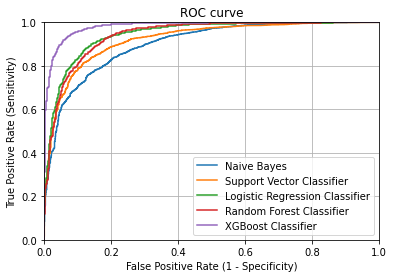

In [21]:
y_pred_prob1 = model_C.predict_proba(X_test1_fitted)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob1)
y_pred_prob2 = svc_clf.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_prob2)
y_pred_prob3 = lr_clf.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_prob3)
y_pred_prob4 = rf_clf.predict_proba(X_test)[:, 1]
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_prob4)
y_pred_prob5 = xgb_clf.predict_proba(X_test)[:, 1]
fpr5, tpr5, thresholds = roc_curve(y_test, y_pred_prob5)

plt.plot(fpr1, tpr1, label = "Naive Bayes")
plt.plot(fpr2, tpr2, label ="Support Vector Classifier")
plt.plot(fpr3, tpr3, label = "Logistic Regression Classifier")
plt.plot(fpr4, tpr4, label ="Random Forest Classifier")
plt.plot(fpr5, tpr5, label ="XGBoost Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)